In [1]:
import networkx as nx
import random
import copy


In [22]:
#The maximum number of evolution
TMAX = 10000
#Forgiveness
PFOR = 0.0
#update type
UPDATETYPE = 'st'
#Evolutionary rate
PEVO = 0.05

#Small world graph
#Each node is connected to k nearest neighbors in ring topology. No odd number
K = 2
#The probability of rewiring each edge
P = 0.3

number_of_nodes = 1000
number_of_edges = 2

In [3]:
#m : Number of edges to attach from a new node to existing nodes
G = nx.barabasi_albert_graph(n = number_of_nodes, m = number_of_edges)


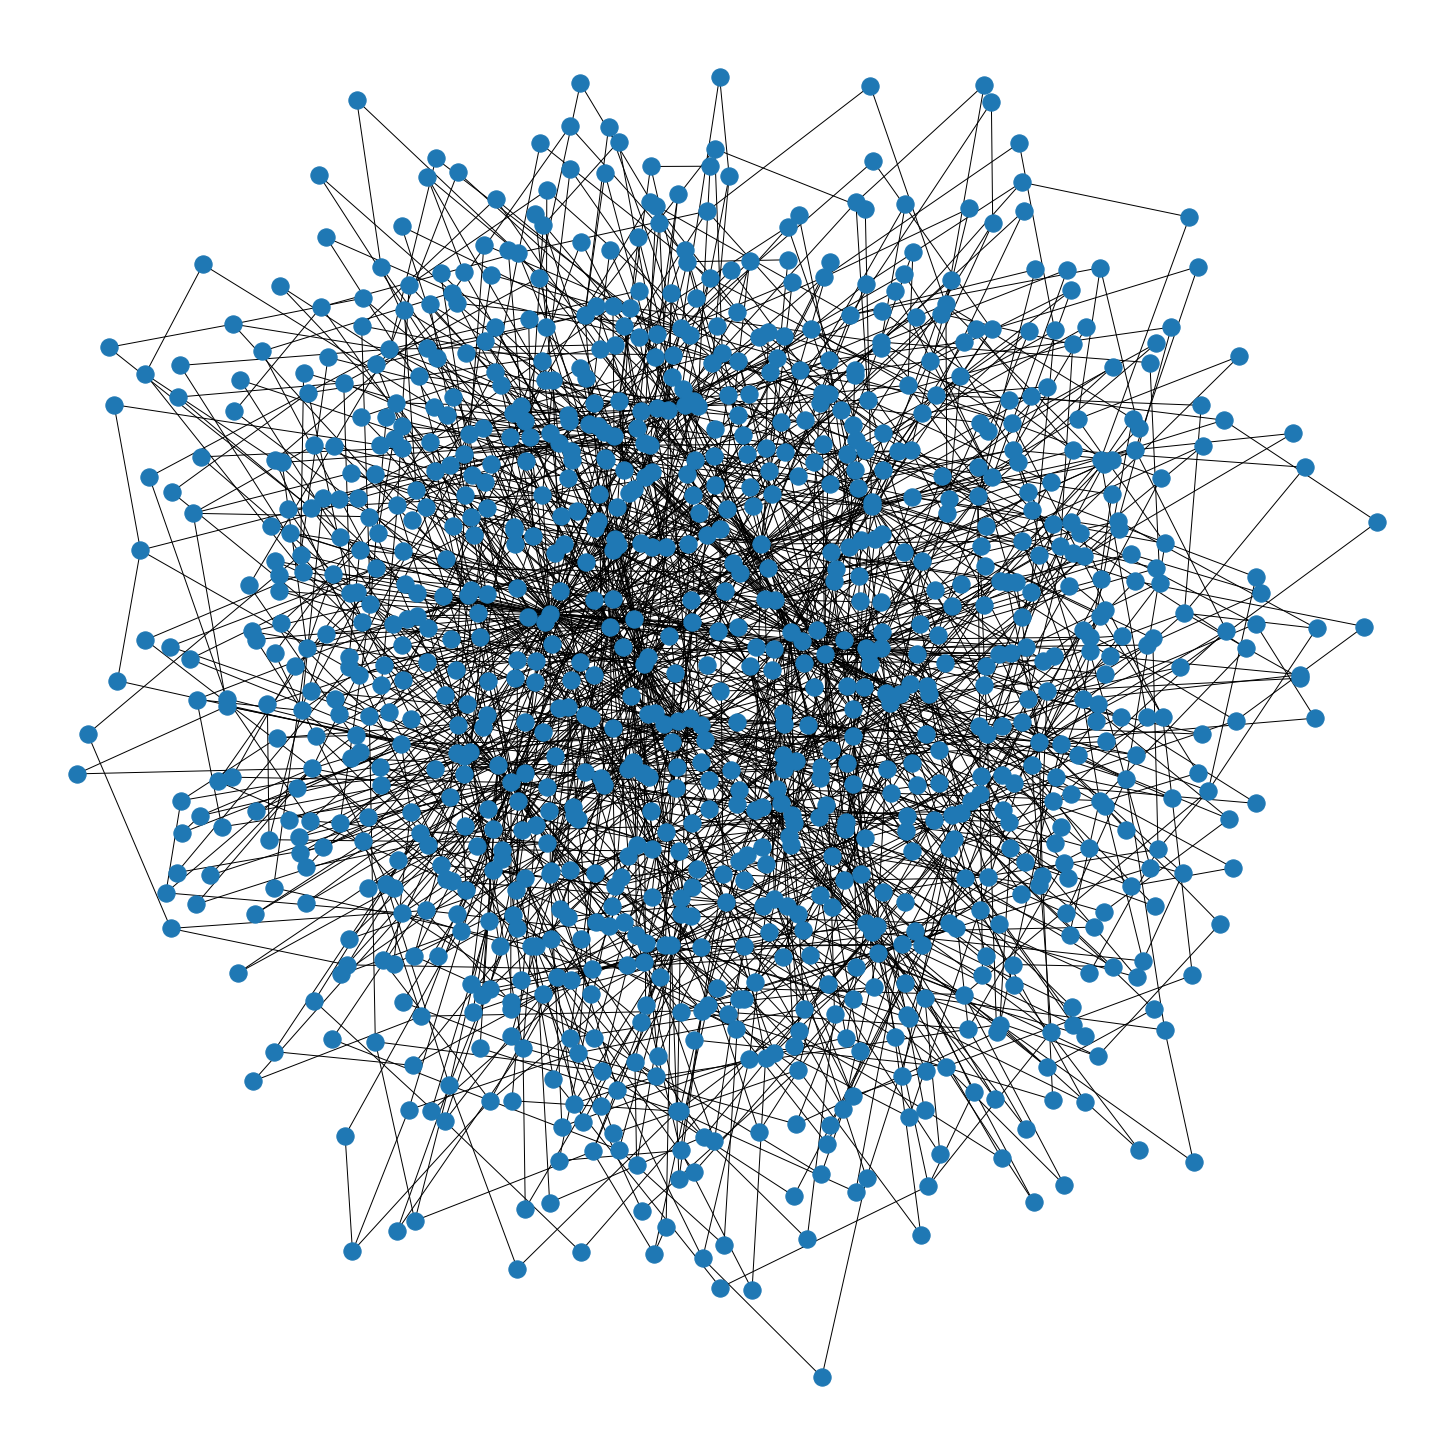

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (20,20))
nx.draw(G)


In [4]:
def play_pd(player, opponent):     
    if (player == 0) and (opponent == 0):
        return 1, 1
    
    elif (player == 0) and (opponent == 1):
        return 5, 0
    
    elif (player == 1) and (opponent == 1):
        return 3, 3
    
    elif (player == 1) and (opponent == 0):
        return 0, 5
        

In [5]:
def decide(player, opponent):
    #UC
    if G.node[player.agent_id]['strategy'] == 0:
        return 1
    #UD
    elif G.node[player.agent_id]['strategy'] == 1:
        return 0
    #TFT
    elif G.node[player.agent_id]['strategy'] == 2:
        # React to the opponent's last move
        if player.agent_id in G.node[opponent.agent_id]['history']:
            if G.node[opponent.agent_id]['history'][player.agent_id] == 1:
                return 1
            else:
                return 0
        #####Code check: if player has history with other opponents but not this opponent, return 1
        else:
            return 1
    #CR
    elif G.node[player.agent_id]['strategy'] == 3:
        return decide_cr(player, opponent)
    
    #UR
    elif G.node[player.agent_id]['strategy'] == 4:
        return decide_ur(player, opponent)
    
    #SJ
    elif G.node[player.agent_id]['strategy'] == 5:
        return decide_sj(player, opponent)
    
    #Print error if not found
    else:
        print('error: undefined strategy type')
        

In [6]:
def play_random():
    if random.random() > 0.5:
        return 1
    else:
        return 0
    

In [7]:
#A function for CR
def decide_cr(player, opponent):
    #Find common neighbors(agent)
    
    A = player.get_neighboring_agents()
    B = opponent.get_neighboring_agents()
    #A list of common friends
    common_neighbors = [element for element in A if element in B]
    #Element type: Player
    
    #If there is no common friends, play randomly
    if len(common_neighbors) == 0:
        return play_random()
    else:
        #randomly select a common friend
        select_rand_friend = random.choice(common_neighbors)
        #Recall last behaviour to thie neighbor
        #If the Other played C against select_rand_friend in the previous step --> cooperate
        if select_rand_friend in G.node[opponent.agent_id]['history']:
            last_move = G.node[opponent.agent_id]['history'][select_rand_friend]
            if last_move == 1:
                return 1
            #If the Other played D against select_rand_friend in the previous step --> defect
            elif last_move == 0:
                #Forgiveness
                #If there is another common friend
                #Find his opinions
                common_neighbors.remove(select_rand_friend)
                if random.random() < PFOR:
                    if len(common_neighbors) > 0 :
                        #Eliminate the guy already choosen from the list of friends
                        #Randomly select anthter friend
                        select_rand_friend_2 = random.choice(common_neighbors)
                        if select_rand_friend_2 in G.node[opponent.agent_id]['history']:
                            last_move_2 = G.node[opponent.agent_id]['history'][select_rand_friend_2]
                            if last_move_2 == 1:
                                return 1
                            elif last_move_2 == 0:
                                return 0
                        else:
                            return play_random()
                else:
                    return 0     
        #If the Other player did not play against select_rand_friend in the previous step --> play randomly
        else:
            return play_random()
        

In [8]:
def decide_ur(player, opponent):
    #Find a list of neighbors of the opponent
    B = opponent.get_neighboring_agents()
    #Eliminate oneself from it
    B.remove(player.agent_id)
    #If the Other player did not play against select_rand_friend in the previous step --> play randomly
    if len(B) == 0:
        return play_random()
    else:
        #Select a random friend
        select_rand_friend = random.choice(B)
        if select_rand_friend in G.node[opponent.agent_id]['history']:
            last_move =  G.node[opponent.agent_id]['history'][select_rand_friend]
            if last_move == 1:
                return 1
            else:
                if random.random() < PFOR:
                    #Give opponent another chance based on another friend
                    B.remove(select_rand_friend)
                    if len(B) == 0:
                        return play_random()
                    else:
                        select_rand_friend_2 = random.choice(B)
                        if select_rand_friend_2 in G.node[opponent.agent_id]['history']:
                            last_move_2 = G.node[opponent.agent_id]['history'][select_rand_friend_2]
                            if last_move_2 == 1:
                                return 1
                            elif last_move_2 == 0:
                                return 0
                        else:
                            #If the Other player did not play against select_rand_friend in the previous step --> play randomly
                            return play_random()
                else:
                    return 0
    
        else:
            return play_random()
    

In [9]:
def decide_sj(player, opponent):
    #Find a list of common friends
    A = player.get_neighboring_agents()
    B = opponent.get_neighboring_agents()
    common_neighbors = [element for element in A if element in B]
    #Play randomly if there is no common friends
    if len(common_neighbors) == 0:
        if random.random() > 0.5:
            return 1
        else:
            return 0
    else:
        #Randomly select a common friend
        select_rand_friend = random.choice(common_neighbors)
        if select_rand_friend in G.node[opponent.agent_id]['history']:
            #Action of Other with common friend
            last_move = G.node[opponent.agent_id]['history'][select_rand_friend]
            #Action of common friend with me
            if player.agent_id in G.node[select_rand_friend]['history']:
                last_move_2 = G.node[select_rand_friend]['history'][player.agent_id]
                #If the opponent cooperate with the common friend
                if last_move == 1: 
                    #If the common friend cooperates with the palyer
                    if last_move_2 == 1:
                        return 1
                    elif last_move_2 == 0:
                        return 0     
                elif last_move == 0:
                    if last_move_2 == 1:
                        return 0
                    elif last_move_2 == 0:
                        return 1
            #####Code change: if there is no interaction between common friend and me
            else:
                return play_random()
        else:
            return play_random()
        

In [10]:
#the strategy is randomly selected
#agent: same as 'process' in SimPy but behaviours are limited
#by its network
class Player():
    
    def __init__(self, agent_id):
        #Using agent_id to present strategy
        #0: UC
        #1: UD
        #2: TFT
        #3: CR
        #4: UR
        #5: SJ
        self.agent_id = agent_id
    
    def update_payoff(self, payoff):
        G.node[self.agent_id]['payoff'] += payoff
    
    #decide to cooperate or defect by its strategy
    def update_behavior(self, neighbor):
        G.node[self.agent_id]['behavior'] = decide(self, neighbor)
        
    def update_cooperation(self):
        G.node[self.agent_id]['cooperation'] += 1
    
    #A dictionary recording last behaviour to a certain neifhbor
    def update_history(self, neighbor):
        #pass
        G.node[self.agent_id]['history_t1'][neighbor] = G.node[self.agent_id]['behavior']
        
    def get_neighboring_agents(self):
        return list(G.neighbors(self.agent_id))
        
    def update_strategy(self):
        #Copy the best
        if UPDATETYPE == 'st':
            if random.random() < PEVO:
                #All connections
                neighbors = self.get_neighboring_agents()
                #Also take in consideration itself
                neighbors.append(self.agent_id)
                #Find the maximum payoff in i neighbourhood
                max_payoff = max([G.node[neighbor]['payoff']/len(list(G.neighbors(neighbor))) for neighbor in neighbors])
                #Find who are the agents carrying that payoff
                max_payoffs = [neighbor for neighbor in neighbors if G.node[neighbor]['payoff']/len(list(G.neighbors(neighbor))) == max_payoff]
                #Randomly choose one of them
                neighbor = random.choice(max_payoffs)
                #Transform itself in that agent
                G.node[self.agent_id]['strategy'] = G.node[neighbor]['strategy']
            else:
                pass
        #Copy the (strictly) better
        else:
            if random.random() < PEVO:
                #All connections
                neighbors = self.get_neighboring_agents()
                #Also take in consideration itself
                neighbors.append(self.agent_id)
                #Select those who have larger payoffs than myself
                larger_payoffs = [neighbor for neighbor in neighbors if G.node[neighbor]['payoff']/len(list(G.neighbors(neighbor))) > G.node[self.agent_id]['payoff']/len(list(G.neighbors(self.agent_id)))]
                if len(larger_payoffs) > 0:
                    #Randomly choose one of them
                    neighbor = random.choice(larger_payoffs)
                    G.node[self.agent_id]['strategy'] = G.node[neighbor]['strategy']  
                else:
                    pass
    
    def game(self):
        my_neighbors = self.get_neighboring_agents()
        if not my_neighbors:
            print('error: isolate node - neighbor is None')
        else:
            for neighbor in my_neighbors:
                #If they have played before, do not replay the game
                if self.agent_id in G.node[neighbor]['play_record']:
                    pass
                else:
                    
                    G.node[self.agent_id]['play_record'].append(neighbor)
                    
                    neighbor_agent = G.node[neighbor]['agent']
                    #now .behavior is behaviour at t-1
                    #new_behavior is behaviour at t
                    self.update_behavior(neighbor_agent)
                    neighbor_agent.update_behavior(self)
                    
                    #Record if cooperates or not
                    if G.node[self.agent_id]['behavior'] == 1:
                        self.update_cooperation()
                    
                    if G.node[neighbor]['behavior'] == 1:
                        neighbor_agent.update_cooperation()
                        
                    #payoff at time t
                    my_payoff, neighbor_payoff = play_pd(G.node[self.agent_id]['behavior'], G.node[neighbor]['behavior'])
                    
                    #update total payoff
                    self.update_payoff(my_payoff)
                    neighbor_agent.update_payoff(neighbor_payoff)
                    
                    #update history in ordert to make decision fo t+1
                    self.update_history(neighbor)
                    neighbor_agent.update_history(self.agent_id)
    

In [17]:
def check_ratio():
    #Set up counters
    uc = 0
    ud = 0
    tft = 0
    cr = 0
    ur = 0
    sj = 0
    
    for i in G.nodes:
        if G.node[i]['strategy'] == 0:
            uc += 1
        elif G.node[i]['strategy'] == 1:
            ud += 1
        elif G.node[i]['strategy'] == 2:
            tft += 1
        elif G.node[i]['strategy'] == 3:
            cr += 1
        elif G.node[i]['strategy'] == 4:
            ur += 1
        else:
            sj += 1
            
    rate_uc = uc/number_of_nodes
    rate_ud = ud/number_of_nodes
    rate_tft = tft/number_of_nodes
    rate_cr = cr/number_of_nodes
    rate_ur = ur/number_of_nodes
    rate_sj = sj/number_of_nodes
    
    result = [rate_uc, rate_ud, rate_tft, rate_cr, rate_ur, rate_sj]
    
    return result
    

In [18]:
def initial_stra_ratio(p0, p1, p2, p3, p4, p5):
    
    return random.random(population = range(6), weights = [p0, p1, p2, p3, p4, p5])


In [19]:
#Initialise the nodes
def init_all_nodes():
    for i in range(number_of_nodes):
        #Each node have a dict memory for neighbours' behaviours
        G.node[i]['history'] = {}
        G.node[i]['history_t1'] = {}
        #Check if played already
        G.node[i]['play_record'] = []
        #For calculating the proportion of cooperation
        G.node[i]['cooperation'] = 0
        #Record of own payoff after interacting with all neighbours
        G.node[i]['payoff'] = 0
        #Record of own strategy
        G.node[i]['behavior'] = None
        G.node[i]['strategy'] = random.choice(range(6))
        G.node[i]['agent'] = Player(i)
    
    #Task: different ratio of strategies
    
    

In [ ]:
counter = 0

f = open('test_result.txt', 'w+')

for experiment in range(100):
    print(experiment)
    f.write('experient number:')
    f.write('{}'.format(experiment))
    f.write('\n')
    
    init_all_nodes()
    
    while True:
        for i in range(number_of_nodes):
            G.node[i]['agent'].game()
               
        for i in range(number_of_nodes):
            G.node[i]['agent'].update_strategy()
    
        #Proportion of cooperation
        #Sigma C (only the last evolution) over Sigam d(degree of nodes)
        no_cooperation = 0
        for i in range(number_of_nodes):
            no_cooperation += G.node[i]['cooperation']
        
        cooperation_ratio = (no_cooperation/2)/G.number_of_edges()
        f.write("cooperation ratio:")
        f.write('{}'.format(cooperation_ratio))
        f.write('\n')
    
        for i in range(number_of_nodes):
            G.node[i]['payoff'] = 0
            G.node[i]['pay_record'] = []
            G.node[i]['history'] = copy.deepcopy(G.node[i]['history_t1'])
            G.node[i]['history_t1'].clear()
            G.node[i]['cooperation'] = 0
    
        f.write("rate_uc, rate_ud, rate_tft, rate_cr, rate_ur, rate_sj:")
        B = check_ratio()
    
        for ratio in B:
            f.write('{}'.format(ratio))
            print(ratio)
        
        f.write('\n')
    
    
        #Stopping condition
        if 1 in B:
            break
    
        if counter == TMAX:
            f.write("Reaches 100000 rounds.")
            break

f.close()
            
                

0
0.16
0.166
0.154
0.176
0.163
0.181
0.155
0.171
0.159
0.177
0.159
0.179
0.148
0.18
0.153
0.178
0.162
0.179
0.146
0.18
0.157
0.176
0.163
0.178
0.136
0.181
0.159
0.184
0.161
0.179
0.134
0.183
0.158
0.19
0.161
0.174
0.13
0.19
0.153
0.185
0.164
0.178
0.128
0.188
0.152
0.187
0.164
0.181
0.128
0.197
0.146
0.187
0.163
0.179
0.122
0.202
0.147
0.185
0.165
0.179
0.12
0.206
0.151
0.184
0.164
0.175
0.118
0.207
0.15
0.184
0.166
0.175
0.114
0.209
0.149
0.189
0.163
0.176
0.112
0.216
0.153
0.183
0.159
0.177
0.11
0.213
0.152
0.188
0.157
0.18
0.11
0.214
0.153
0.189
0.156
0.178
0.105
0.219
0.151
0.188
0.157
0.18
0.104
0.223
0.153
0.184
0.157
0.179
0.096
0.227
0.157
0.183
0.157
0.18
0.095
0.232
0.155
0.181
0.163
0.174
0.093
0.233
0.154
0.188
0.159
0.173
0.092
0.233
0.154
0.187
0.158
0.176
0.089
0.235
0.156
0.186
0.156
0.178
0.091
0.234
0.153
0.183
0.157
0.182
0.091
0.232
0.153
0.186
0.159
0.179
0.087
0.223
0.156
0.191
0.161
0.182
0.085
0.22
0.157
0.192
0.163
0.183
0.085
0.221
0.157
0.193
0.161
0.183
0.08

0.0
0.03
0.323
0.17
0.255
0.222
0.0
0.03
0.324
0.17
0.252
0.224
0.0
0.03
0.322
0.174
0.253
0.221
0.0
0.031
0.324
0.169
0.252
0.224
0.0
0.03
0.326
0.172
0.252
0.22
0.0
0.03
0.329
0.173
0.248
0.22
0.0
0.03
0.325
0.172
0.253
0.22
0.0
0.029
0.323
0.176
0.253
0.219
0.0
0.03
0.329
0.173
0.245
0.223
0.0
0.032
0.332
0.173
0.241
0.222
0.0
0.031
0.332
0.176
0.241
0.22
0.0
0.034
0.332
0.17
0.242
0.222
0.0
0.033
0.343
0.166
0.239
0.219
0.0
0.032
0.347
0.162
0.241
0.218
0.0
0.032
0.344
0.161
0.246
0.217
0.0
0.03
0.353
0.163
0.241
0.213
0.0
0.029
0.353
0.165
0.242
0.211
0.0
0.028
0.353
0.163
0.239
0.217
0.0
0.028
0.351
0.163
0.237
0.221
0.0
0.027
0.35
0.162
0.237
0.224
0.0
0.026
0.354
0.162
0.239
0.219
0.0
0.025
0.354
0.165
0.237
0.219
0.0
0.025
0.354
0.168
0.239
0.214
0.0
0.024
0.356
0.166
0.24
0.214
0.0
0.024
0.358
0.162
0.242
0.214
0.0
0.023
0.361
0.162
0.241
0.213
0.0
0.023
0.367
0.163
0.241
0.206
0.0
0.023
0.369
0.159
0.242
0.207
0.0
0.022
0.37
0.16
0.239
0.209
0.0
0.023
0.372
0.157
0.242
0.206

In [ ]:
#Plot graphs: error bar
#Barabasi book

#exploration
#Draw equally spacing log graph and equally decrease graph
#scale free: pro of cooperation vs gamma [2,4] in steps of 0.1/0.2
#smallworld: pro of cooperation vs P[0, 1] 

In [ ]:
G_1 = nx.watts_strogatz_graph(n = number_of_nodes, k = )